# Geekbrains university
## Домашняя работа по курсу "Базы данных для аналитиков. Основы ETL" к уроку №  4 "Типовая аналитика маркетинговой активности"

### Работу выполнил Мазейко Вадим 
03.11.2019

### Задание №1. На основе данных по продажам за 16 и 17 год на основе когортного анализа по дате первой покупки спрогнозировать товарооборот января 2018 года (с выводом кэфов поведения когротны по порядковому номеру месяца)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import os

In [2]:
pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2
pd.set_option('display.float_format', '{:.0f}'.format) # Делаем нормальную выдачу чисел, без Е.

%matplotlib inline

In [3]:
os.chdir('C:/Users/User/Google Диск/Learning/geekbrains/DB4Analytics') # меняем рабочую директорию
df = pd.read_csv('orders.csv', sep=";") # загрузка файла

### Обрабатываем датафрейм:

In [4]:
df['o_date'] = df['o_date'].astype('datetime64[D]') # Меняем тип столбца с str на datetime64 
df['price'] = df['price'].apply(lambda x : float(x.replace(',','.'))) # заменяем запятую на точку в ценах
#NOW = dt.datetime(2017, 12, 31) # заполняем позицию "сейчас"

### Далее делаем когортный анализ датафрейма. 
При выполнении работы использован код http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/

Формируем новый столбец с указанием месяца и года первой покупки:

Формируем столбец с когортами:

In [5]:
df.set_index('user_id', inplace=True)
df['CohortGroup'] = df.groupby(level=0)['o_date'].min().apply(lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)
df.head()

,user_id,id_o,price,o_date,CohortGroup
0,337544,1234491,539,2016-01-01,2016-01
1,171642,1234494,153,2016-01-01,2016-01
2,260596,1234497,55,2016-01-01,2016-01
3,1105609,1234498,752,2016-01-01,2016-01
4,982696,1234500,4410,2016-01-01,2016-01


In [8]:
df['OrderPeriod'] = df['o_date'].apply(lambda x: x.strftime('%Y-%m'))
df.head()

,user_id,id_o,price,o_date,CohortGroup,OrderPeriod
0,337544,1234491,539,2016-01-01,2016-01,2016-01
1,171642,1234494,153,2016-01-01,2016-01,2016-01
2,260596,1234497,55,2016-01-01,2016-01,2016-01
3,1105609,1234498,752,2016-01-01,2016-01,2016-01
4,982696,1234500,4410,2016-01-01,2016-01,2016-01


In [9]:
grouped = df.groupby(['CohortGroup', 'OrderPeriod'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'id_o': pd.Series.nunique,
                       'price': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'user_id': 'TotalUsers',
                        'id_o': 'TotalOrders',
                        'price': 'TotalCharges'}, inplace=True)
cohorts.head()

TotalUsers  TotalOrders  TotalCharges
CohortGroup OrderPeriod                                       
2016-01     2016-01           41624        53246     112520331
            2016-02            6042        11663      23992289
            2016-03            6954        14551      26709014
            2016-04            6953        14925      27605884
            2016-05            6543        14558      26926095

Назовём периоды каждой когорты: 

In [10]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalUsers  TotalOrders  TotalCharges  CohortPeriod
CohortGroup OrderPeriod                                                     
2016-01     2016-01           41624        53246     112520331             1
            2016-02            6042        11663      23992289             2
            2016-03            6954        14551      26709014             3
            2016-04            6953        14925      27605884             4
            2016-05            6543        14558      26926095             5

Выполним проверку данных:

In [11]:
# x = df[(df.CohortGroup == '2017-01') & (df.OrderPeriod == '2017-01')]
# y = cohorts.loc[('2017-01', '2017-01')]

# assert(x['user_id'].nunique() == y['TotalUsers'])
# assert(x['price'].sum().round(2) == y['TotalCharges'].round(2))
# assert(x['id_o'].nunique() == y['TotalOrders'])

# x = df[(df.CohortGroup == '2017-01') & (df.OrderPeriod == '2017-09')]
# y = cohorts.loc[('2017-01', '2017-09')]

# assert(x['user_id'].nunique() == y['TotalUsers'])
# assert(x['price'].sum().round(2) == y['TotalCharges'].round(2))
# assert(x['id_o'].nunique() == y['TotalOrders'])

# x = df[(df.CohortGroup == '2017-05') & (df.OrderPeriod == '2017-09')]
# y = cohorts.loc[('2017-05', '2017-09')]

# assert(x['user_id'].nunique() == y['TotalUsers'])
# assert(x['price'].sum().round(2) == y['TotalCharges'].round(2))
# assert(x['id_o'].nunique() == y['TotalOrders'])

Делаем серию с с когортами:

In [12]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2016-01    41624
2016-02    31406
2016-03    37177
2016-04    34187
2016-05    30950
Name: TotalUsers, dtype: int64

In [13]:
cohorts['TotalUsers'].head()

CohortGroup  CohortPeriod
2016-01      1               41624
             2                6042
             3                6954
             4                6953
             5                6543
Name: TotalUsers, dtype: int64

In [14]:
cohorts['TotalUsers'].unstack(0).head()

CohortGroup,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
CohortPeriod,,,,,,,,,,,,,,,,,,,,,,,,
1,41624,31406,37177,34187,30950,28374,28408,31353,32602,39732,50995,58284,44519,38165,42607,39903,46173,41416,42249,43326,41385,49078,61608,79598
2,6042,3645,3845,2855,2151,1720,1685,1637,1667,1850,2314,1948,2606,2264,2204,2068,1926,1635,1469,1379,1547,1912,2189,nan
3,6954,3506,3411,2401,1851,1750,1480,1702,1755,1701,1625,1497,2787,1922,2244,1702,1730,1488,1301,1352,1495,1682,nan,nan
4,6953,3406,3188,2351,1908,1703,1557,1763,1601,1241,1257,1594,2593,2185,2035,1702,1687,1372,1462,1554,1427,nan,nan,nan
5,6543,3135,2910,2457,1956,1799,1598,1714,1118,979,1394,1464,2938,2013,1994,1610,1561,1503,1719,1502,nan,nan,nan,nan


In [15]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
CohortPeriod,,,,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan,nan
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan,nan,nan


In [16]:
# user_retention[['2016-01', '2016-07', '2016-12']].plot(figsize=(10,5))
# plt.title('Cohorts: User Retention')
# plt.xticks(np.arange(1, 12.1, 1))
# plt.xlim(1, 12)
# plt.ylabel('% of Cohort Purchasing');

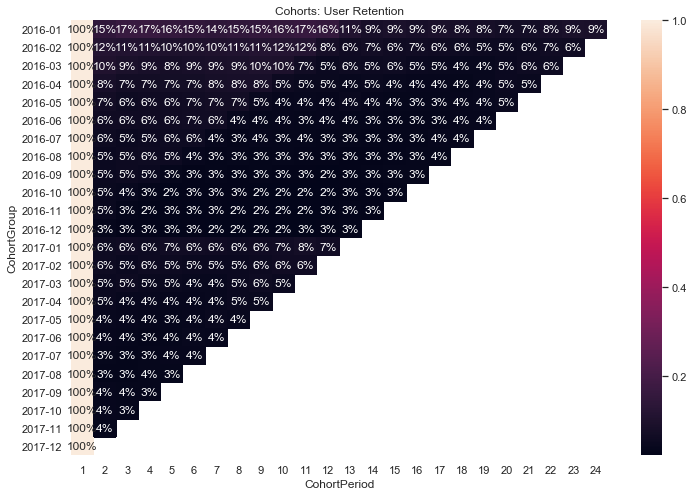

In [17]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

P.S. Как вы сами говорили, нет смысла использовать когортный анализ для помесячных прогнозов - слишком велика погрешность. 
Для этого замечательно подойдёт использование линейной регрессии

### Задание №2. Продумать, как можно сделать объединение пользователей (мердж) по совпадению контактных данных. Кусок данных в материалах к уроку. (на занятии обсуждали)

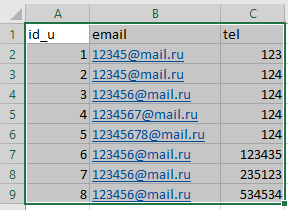


Самым логичным мне кажется перепривязать пользователя к телефону. 
Логика следующая: Диспетчер осуществляет связь по телефону. Соответственно, телефон - реально действующий. Однако возможна ситуация что у одного юзера несколько телефонов (мама, папа, подруга, няня, бабушка - тот, кто будет дома в момент доставки) Соответвенно логично будет сделать объект с атрибутами - почта и телефон. Каждый атрибут - массив совпадающих сущностей в графах email и tel. Естественно, туда же можно будет забить способ оплаты, адреса доставки и т.д.

По реализации возможно много вариантов в зависимости от архитектуры базы данных. Лично мне импонирует использование внешнего выхода из БД на NoSQL. При забивке новых данных отправлял запрос на совпадение и предлагал залогиниться под данным пользователем. 

Для  единоразовой задачи я бы использовал pandas.